In [1]:
import Car
import CarTrajectory
import CyclicSimulation
import Event
import FCFSSimulation
import FES
import Lane
import SimResults

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import copy
import scipy.stats as st
import heapq
import pandas as pd
from collections import deque
from numpy.ma.core import zeros



In [3]:
rng = np.random.default_rng()

#import the given arrivals document
#timeLst = pd.read_csv('arrivals22.csv', sep = ';', header = None).to_numpy()
timeLst = pd.read_excel('arrivals22.xlsx', header = None).to_numpy()
#timeLst = np.array([[1,2.3],[2,3.3],[4.8,3.5],[9.2,5.2],[30,7.0],[31,8.1],[32,10.0]])
print(timeLst)
nCarPerLane, lanes = np.shape(timeLst)
b = 1
s = 2.4
laneLst = []
alphaLst = np.zeros(lanes)
muLst = np.zeros(lanes)
for n in range(lanes):
    laneLst.append(Lane(n, timeLst[:,n], b))
    laneLst[n].printAlphaMu()
    laneLst[n].testAlphaMu()
    alphaLst[n] = laneLst[n].alpha
    muLst[n] = laneLst[n].mu

FileNotFoundError: [Errno 2] No such file or directory: 'arrivals22.xlsx'

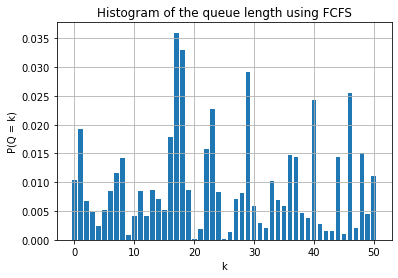

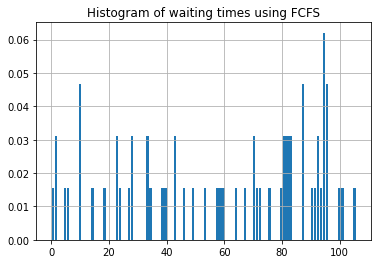

Mean queue length: 48.382859392451785
Variance queue length: 683.0017792397175
Mean waiting time: 58.53836337501076
Variance waiting time: 1049.57263809812
Confidence Interval for the waiting time is(50.17222031222286, 66.90450643779864)



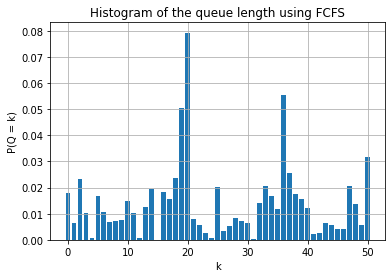

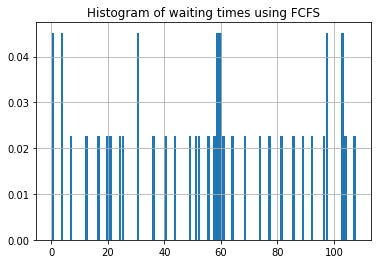

Mean queue length: 35.77595741287902
Variance queue length: 434.8745802992694
Mean waiting time: 54.2071305102876
Variance waiting time: 1059.6896443847663
Confidence Interval for the waiting time is(43.80453140933117, 64.60972961124402)



In [ ]:
vm = 13
x0 = 300
sim = FCFSSimulation(lanes, alphaLst, muLst, b, s, vm, x0)
table , results = sim.simulate(100)
_, counts = np.unique(table[:, 0], return_counts = True)
carLstOut = np.zeros((max(counts), 2 * lanes))
for n in range(lanes):
    laneArray = table[table[:, 0] == n]
    laneArray = np.pad(laneArray, ((0, max(counts) - counts[n]), (0, 0)), 'constant', constant_values=0)
    carLstOut[:, 2 * n] = laneArray[:, 1]
    carLstOut[:, 1 + 2 * n] = laneArray[:, 2]

for lane in range(lanes):
    results[lane].histQueueLength() # plot of the queue length
    results[lane].histWaitingTimes() # histogram of waiting times
    print(str(results[lane])) #confidence interval of waiting times

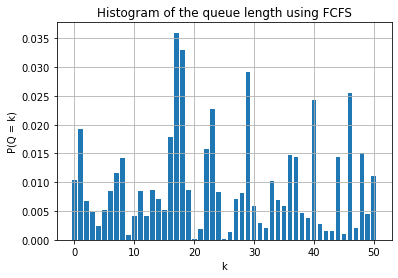

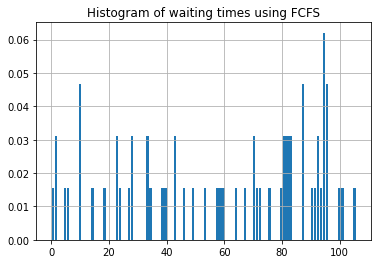

Mean queue length: 48.382859392451785
Variance queue length: 683.0017792397175
Mean waiting time: 58.53836337501076
Variance waiting time: 1049.57263809812
Confidence Interval for the waiting time is(50.17222031222286, 66.90450643779864)



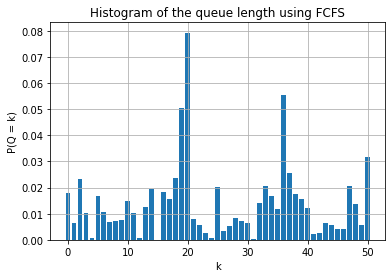

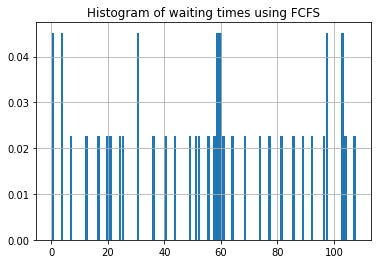

Mean queue length: 35.77595741287902
Variance queue length: 434.8745802992694
Mean waiting time: 54.2071305102876
Variance waiting time: 1059.6896443847663
Confidence Interval for the waiting time is(43.80453140933117, 64.60972961124402)



In [ ]:
vm = 13
x0 = 300
sim = CyclicSimulation(lanes, alphaLst, muLst, b, s, vm, x0)
table, res = sim.simulate(100)
_, counts = np.unique(table[:, 0], return_counts = True)
carLstOutC = np.zeros((max(counts), 2 * lanes))
for n in range(lanes):
    laneArray = table[table[:, 0] == n]
    laneArray = np.pad(laneArray, ((0, max(counts) - counts[n]), (0, 0)), 'constant', constant_values=0)
    carLstOutC[:, 2 * n] = laneArray[:, 1]
    carLstOutC[:, 1 + 2 * n] = laneArray[:, 2]

for lane in range(lanes):
    results[lane].histQueueLength() # plot of the queue length
    results[lane].histWaitingTimes() # histogram of waiting times
    print(str(results[lane])) #confidence interval of waiting times

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#import from csv assuming the datastructure is arrival time lane 0; departure time lane 0; arr t l1, dep t l1, etc assumed for each lane to have its cars chronologically ordered
#carLst = pd.read_csv('cars22.csv', sep = ';', header = None).to_numpy() #Example
#carLst = carLstOut    #array FCFS
carLst = carLstOutC    #array CES

#setting variables according to assignment
nCarPerLane, lanes = np.shape(carLst)
lanes = int(lanes / 2)
am = 3
vm = 13
x0 = 300
b = 1
minT = x0 / vm
stopDist = b * vm
prevCar = CarTrajectory(-minT, 0, am, vm, x0)

#plot settings
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_ylabel('Distance')
ax.set_xlabel('Time')
ax.xaxis.set_label_coords(1.11, 0.5)

for i in range(lanes):
    for n in range(nCarPerLane):
        if n > 0 and carLst[n, 2 * i] < (prevCar.dep - minT): # pass data on previous car if too close
            car = CarTrajectory(carLst[n, 2 * i], carLst[n, 1 + 2 * i], am, vm, x0, stopDist, prevCar.xFullEnd)
        else:
            car = CarTrajectory(carLst[n, 2 * i], carLst[n, 1 + 2 * i], am, vm, x0)
        prevCar = car
        #get time and trajectory output for specific car at roughly 0.5s intervals (makes them shorter if nessecary to also fit both the start and end point)
        time, distance = car.trajectory(0.5)
        #generate plot line from trajectory for said car
        if i == 1:
            distance = distance * -1
            clr = 'r'
        else:
            clr = 'b'
        plt.plot(time, distance, color=clr)

#more plot settings
plt.title('Trajectories of 100 vehicles')
plt.axis([0.1, 120, -300, 300])
plt.axhline(0, color='k')
plt.show()